In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

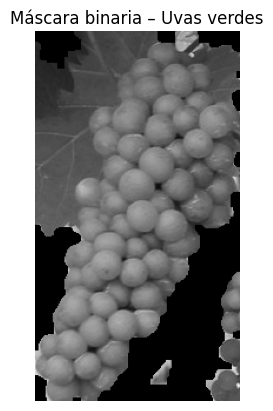

In [ ]:

# Cambiar la ubicación de acuerdo en donde se guarda las imagenes segmentadas
mask_verde = cv2.imread(r"C:\Users\YOSEF\Downloads\yolov8-grape-cluster-yield-main\yolov8-grape-cluster-yield-main\src\segmentation\uvas_verdes.png", cv2.IMREAD_GRAYSCALE)
mask_roja = cv2.imread(r"C:\Users\YOSEF\Downloads\yolov8-grape-cluster-yield-main\yolov8-grape-cluster-yield-main\src\segmentation\uvas_rojas.png", cv2.IMREAD_GRAYSCALE)
mask_morada = cv2.imread(r"C:\Users\YOSEF\Downloads\yolov8-grape-cluster-yield-main\yolov8-grape-cluster-yield-main\src\segmentation\uvas_moradas.png", cv2.IMREAD_GRAYSCALE)


plt.imshow(mask_verde, cmap="gray")
plt.title("Máscara binaria – Uvas verdes")
plt.axis("off")
plt.show()


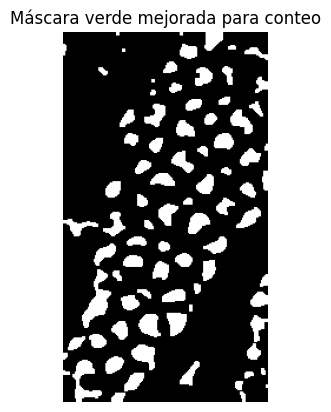

In [3]:
def preparar_mascara_para_conteo(mask, 
                                 ksize_blur=(7, 7),
                                 block_size=35,
                                 C=-5,
                                 erosion_iters=1,
                                 area_minima_bin=0):
    """
    A partir de una máscara de uvas (posiblemente pegadas) genera una máscara
    'mejorada' donde las uvas aparecen más separadas, lista para aplicar
    análisis de componentes conectados.

    Pasos:
    - Desenfoque Gaussiano (suaviza ruido).
    - Umbral adaptativo (segmentación local).
    - Erosión ligera (separa uvas que comparten bordes finos).
    - Apertura morfológica (elimina ruido pequeño).
    """
    if mask is None:
        return None

    # 1) Desenfoque
    blur = cv2.GaussianBlur(mask, ksize_blur, 0)

    # 2) Umbral adaptativo
    th = cv2.adaptiveThreshold(
        blur,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        block_size,
        C
    )

    # 3) Erosión ligera
    kernel3 = np.ones((3, 3), np.uint8)
    th_eroded = cv2.erode(th, kernel3, iterations=erosion_iters)

    # 4) Apertura leve
    th_clean = cv2.morphologyEx(th_eroded, cv2.MORPH_OPEN, kernel3, iterations=1)

    # Opcional: eliminar manchas diminutas directamente aquí (área mínima)
    if area_minima_bin > 0:
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(th_clean)
        mask_filtrada = np.zeros_like(th_clean)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= area_minima_bin:
                mask_filtrada[labels == i] = 255
        th_clean = mask_filtrada

    return th_clean

# Crear máscaras separadas para el conteo (por ahora solo filtramos verde)
mask_verde_sep  = preparar_mascara_para_conteo(mask_verde)
mask_roja_sep   = preparar_mascara_para_conteo(mask_roja)   if mask_roja   is not None else None
mask_morada_sep = preparar_mascara_para_conteo(mask_morada) if mask_morada is not None else None

plt.imshow(mask_verde_sep, cmap='gray')
plt.title("Máscara verde mejorada para conteo")
plt.axis("off")
plt.show()


In [4]:
def contar_uvas_en_mascara(mask_binaria, area_minima):
    """
    Implementa el 'análisis de componentes conectados' sobre una máscara binaria:
    - Agrupa píxeles conectados que pertenecen a una misma uva.
    - Etiqueta cada uva como un componente independiente.
    - Aplica un filtro por área mínima para descartar componentes pequeños o fragmentados.

    Devuelve:
    - conteo de uvas
    - labels, stats, centroids, indices_validos: para visualización opcional
    """
    if mask_binaria is None:
        return 0, None, None, None, []

    # Aseguramos binarización estricta (0 o 255)
    _, mask_bin = cv2.threshold(mask_binaria, 127, 255, cv2.THRESH_BINARY)

    # Análisis de componentes conectados
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_bin)

    conteo = 0
    indices_validos = []

    # El label 0 es el fondo → empezamos en 1
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]

        # "Los componentes muy pequeños o fragmentados… pueden ser descartados
        # mediante filtros de tamaño mínimo"
        if area >= area_minima:
            conteo += 1
            indices_validos.append(i)

    return conteo, labels, stats, centroids, indices_validos


In [5]:
def estimar_uvas_por_racimo(mask_verde_sep=None,
                            mask_roja_sep=None,
                            mask_morada_sep=None,
                            area_minima=30):
    """
    Sigue la metodología:
    - Utiliza las máscaras binarias separadas para cada tipo de uva.
    - Aplica análisis de componentes conectados a cada máscara.
    - Aplica un filtro por área mínima.
    - Suma las uvas de cada color para obtener el total del racimo.
    """
    resultados = {}
    total = 0

    if mask_verde_sep is not None:
        c_v, labels_v, stats_v, cent_v, idx_v = contar_uvas_en_mascara(mask_verde_sep, area_minima)
        resultados["uvas_verdes"] = c_v
        resultados["labels_verde"] = labels_v
        resultados["stats_verde"] = stats_v
        resultados["centros_verde"] = cent_v
        resultados["indices_verde"] = idx_v
        total += c_v

    if mask_roja_sep is not None:
        c_r, labels_r, stats_r, cent_r, idx_r = contar_uvas_en_mascara(mask_roja_sep, area_minima)
        resultados["uvas_rojas"] = c_r
        resultados["labels_roja"] = labels_r
        resultados["stats_roja"] = stats_r
        resultados["centros_roja"] = cent_r
        resultados["indices_roja"] = idx_r
        total += c_r

    if mask_morada_sep is not None:
        c_m, labels_m, stats_m, cent_m, idx_m = contar_uvas_en_mascara(mask_morada_sep, area_minima)
        resultados["uvas_moradas"] = c_m
        resultados["labels_morada"] = labels_m
        resultados["stats_morada"] = stats_m
        resultados["centros_morada"] = cent_m
        resultados["indices_morada"] = idx_m
        total += c_m

    resultados["total_uvas_racimo"] = total
    return resultados


In [22]:
# Ajusta area_minima si tira ruido o se come uvas (20–40 normalmente)
resultado = estimar_uvas_por_racimo(
    mask_verde_sep=mask_verde_sep,
    mask_roja_sep=mask_roja_sep,
    mask_morada_sep=mask_morada_sep,
    area_minima=40
)

print("===== ESTIMACIÓN DE UVAS POR RACIMO (CC + máscaras separadas) =====")
print(f"Uvas verdes:   {resultado.get('uvas_verdes', 0)}")
print(f"Uvas rojas:    {resultado.get('uvas_rojas', 0)}")
print(f"Uvas moradas:  {resultado.get('uvas_moradas', 0)}")
print("-----------------------------------------")
print(f"TOTAL DE UVAS POR RACIMO: {resultado['total_uvas_racimo']}")


===== ESTIMACIÓN DE UVAS POR RACIMO (CC + máscaras separadas) =====
Uvas verdes:   68
Uvas rojas:    0
Uvas moradas:  0
-----------------------------------------
TOTAL DE UVAS POR RACIMO: 68


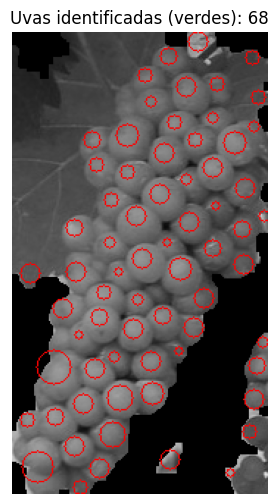

In [23]:

img_vis = cv2.cvtColor(mask_verde, cv2.COLOR_BGR2RGB)

# Dibujar solo verdes en este ejemplo (puedes repetir lógica para rojas/moradas)
labels_v   = resultado.get("labels_verde", None)
stats_v    = resultado.get("stats_verde", None)
centros_v  = resultado.get("centros_verde", None)
indices_v  = resultado.get("indices_verde", [])

if labels_v is not None:
    for i in indices_v:
        cx, cy = centros_v[i]
        cx, cy = int(cx), int(cy)

        area = stats_v[i, cv2.CC_STAT_AREA]
        radio_aprox = int(np.sqrt(area / np.pi))

        cv2.circle(img_vis, (cx, cy), radio_aprox, (255, 0, 0), 1)  # rojo

plt.figure(figsize=(4, 6))
plt.imshow(img_vis)
plt.title(f"Uvas identificadas (verdes): {resultado.get('uvas_verdes', 0)}")
plt.axis("off")
plt.show()
